# Food101 with FastAI - Resnet50 and mixup

This challenge was quite interesting mainly because of label noise, which we will soon see when we begin exploring the validation (test images) set performance.
I was able to bring the model to slightly better than 85% accuracy with the help of mixup. Mixup training is especially useful for noisy labelled data because it allows the small chance that the correct groups of data and label come together through the mix up process.

## Importing libraries

In [151]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
import PIL
import matplotlib.pyplot as plt

In [153]:
import numpy as np
import pandas as pd
from pathlib import Path
path = Path('/media/data/data archive/food/food-101')

In [154]:
import os
os.listdir(path)

['train.json',
 'train.txt',
 'test.json',
 'images',
 'labels.txt',
 'test.txt',
 'h5',
 'classes.txt']

## Reading datafiles and initial exploration

In [184]:
#Reading .json files for exploration
#Each category has 750 train and 250 test images
train_json = pd.read_json(path/'train.json');
test_json  = pd.read_json(path/'test.json') 

In [156]:
train_json.columns.values.tolist()

['churros',
 'hot_and_sour_soup',
 'samosa',
 'sashimi',
 'pork_chop',
 'spring_rolls',
 'panna_cotta',
 'beef_tartare',
 'greek_salad',
 'foie_gras',
 'tacos',
 'pad_thai',
 'poutine',
 'ramen',
 'pulled_pork_sandwich',
 'bibimbap',
 'beignets',
 'apple_pie',
 'crab_cakes',
 'risotto',
 'paella',
 'steak',
 'baby_back_ribs',
 'miso_soup',
 'frozen_yogurt',
 'club_sandwich',
 'carrot_cake',
 'falafel',
 'bread_pudding',
 'chicken_wings',
 'gnocchi',
 'caprese_salad',
 'creme_brulee',
 'escargots',
 'chocolate_cake',
 'tiramisu',
 'spaghetti_bolognese',
 'mussels',
 'scallops',
 'baklava',
 'edamame',
 'macaroni_and_cheese',
 'pancakes',
 'garlic_bread',
 'beet_salad',
 'onion_rings',
 'red_velvet_cake',
 'grilled_salmon',
 'chicken_curry',
 'deviled_eggs',
 'caesar_salad',
 'hummus',
 'fish_and_chips',
 'lasagna',
 'peking_duck',
 'guacamole',
 'strawberry_shortcake',
 'clam_chowder',
 'croque_madame',
 'french_onion_soup',
 'beef_carpaccio',
 'fried_rice',
 'donuts',
 'gyoza',
 'ravio

In [157]:
#getting 3 random samples from an range of numbers
sample = np.random.permutation([x for x in range(750)])[:3]

In [158]:
train_json[train_json.columns[1]][sample]

447    hot_and_sour_soup/3077239
657     hot_and_sour_soup/628858
212    hot_and_sour_soup/1991971
Name: hot_and_sour_soup, dtype: object

oysters


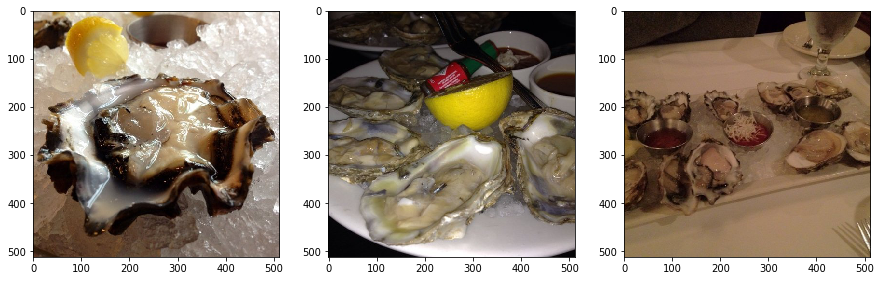

In [160]:
"""
visualizing 3 random samples from train dataset
"""
#first we specify food category that we want to search. we can find specific idx by using list.index() 
food_type = 101 -1
#sample uses permutation to create a random ordering of the index and then selects the first three elements.
sample = np.random.permutation([x for x in range(750)])[:3]
#contains the file names of the sample idxs.
name = train_json[train_json.columns[food_type]][sample]

print(train_json.columns[food_type])

fig, axs = plt.subplots(1,3, figsize=(15,20))

for i in range(3): 
    im = PIL.Image.open(path/'images'/(name[sample[i]]+'.jpg'))
    axs[i].imshow(np.asarray(im))

oysters


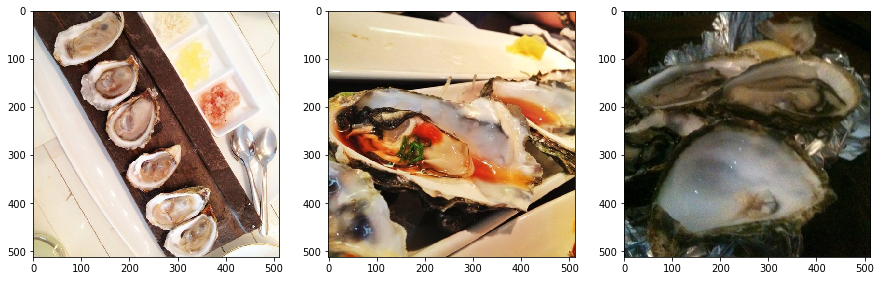

In [194]:
"""
visualizing 3 random samples from test dataset. 

Seeing commented version in train dataset version for explanations
"""

food_type = 101 -1
sample = np.random.permutation([x for x in range(250)])[:3]
name = test_json[test_json.columns[food_type]][sample]

print(test_json.columns[food_type])

fig, axs = plt.subplots(1,3, figsize=(15,20))

for i in range(3): 
    im = PIL.Image.open(path/'images'/(name[sample[i]]+'.jpg'))
    axs[i].imshow(np.asarray(im))  

As we can see above the biggest problem with the dataset apart from the noisy labels are the lighting in restaurants and the lens distortion that phone cameras create in close up photography.

## Data preparation

In [161]:
#This function reads a row from the text files and then outputs a label_name
def labeler_func(x):
    assert isinstance(x,str), f'Should be of type str, got {type(x)} instead'
    return x.split('/')[0]

I am using the train.txt and test.txt files since they are easier to work with especially after creating the labeler function

In [162]:
train_df = pd.read_csv(path/'train.txt', header=None); 
test_df  = pd.read_csv(path/'test.txt',  header=None); 
# train_df.head()
# test_df.head()
train_df['labels'] = train_df[0].apply(labeler_func)
test_df['labels']  = test_df[0].apply(labeler_func)

Creating the train and validation (labeled test set) images next.

In [163]:
train_list = ImageList.from_df(df = train_df, path = path/'images', suffix = '.jpg')
valid_list = ImageList.from_df(df = test_df,  path = path/'images', suffix = '.jpg')

In [164]:
#Checking lists
train_list, valid_list[0]

(ImageList (75750 items)
 Image (3, 512, 308),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
 Path: /media/data/data archive/food/food-101/images, Image (3, 512, 512))

Here I am using Fastai's defined functions to split the databunch with the two imagelists

In [165]:
sd = train_list.split_by_list(train = train_list, valid= valid_list)

In [166]:
tfms = get_transforms()
data = (sd.label_from_df()
          .transform(tfms, size = 224)
          .databunch(bs=32)
          .normalize(imagenet_stats))

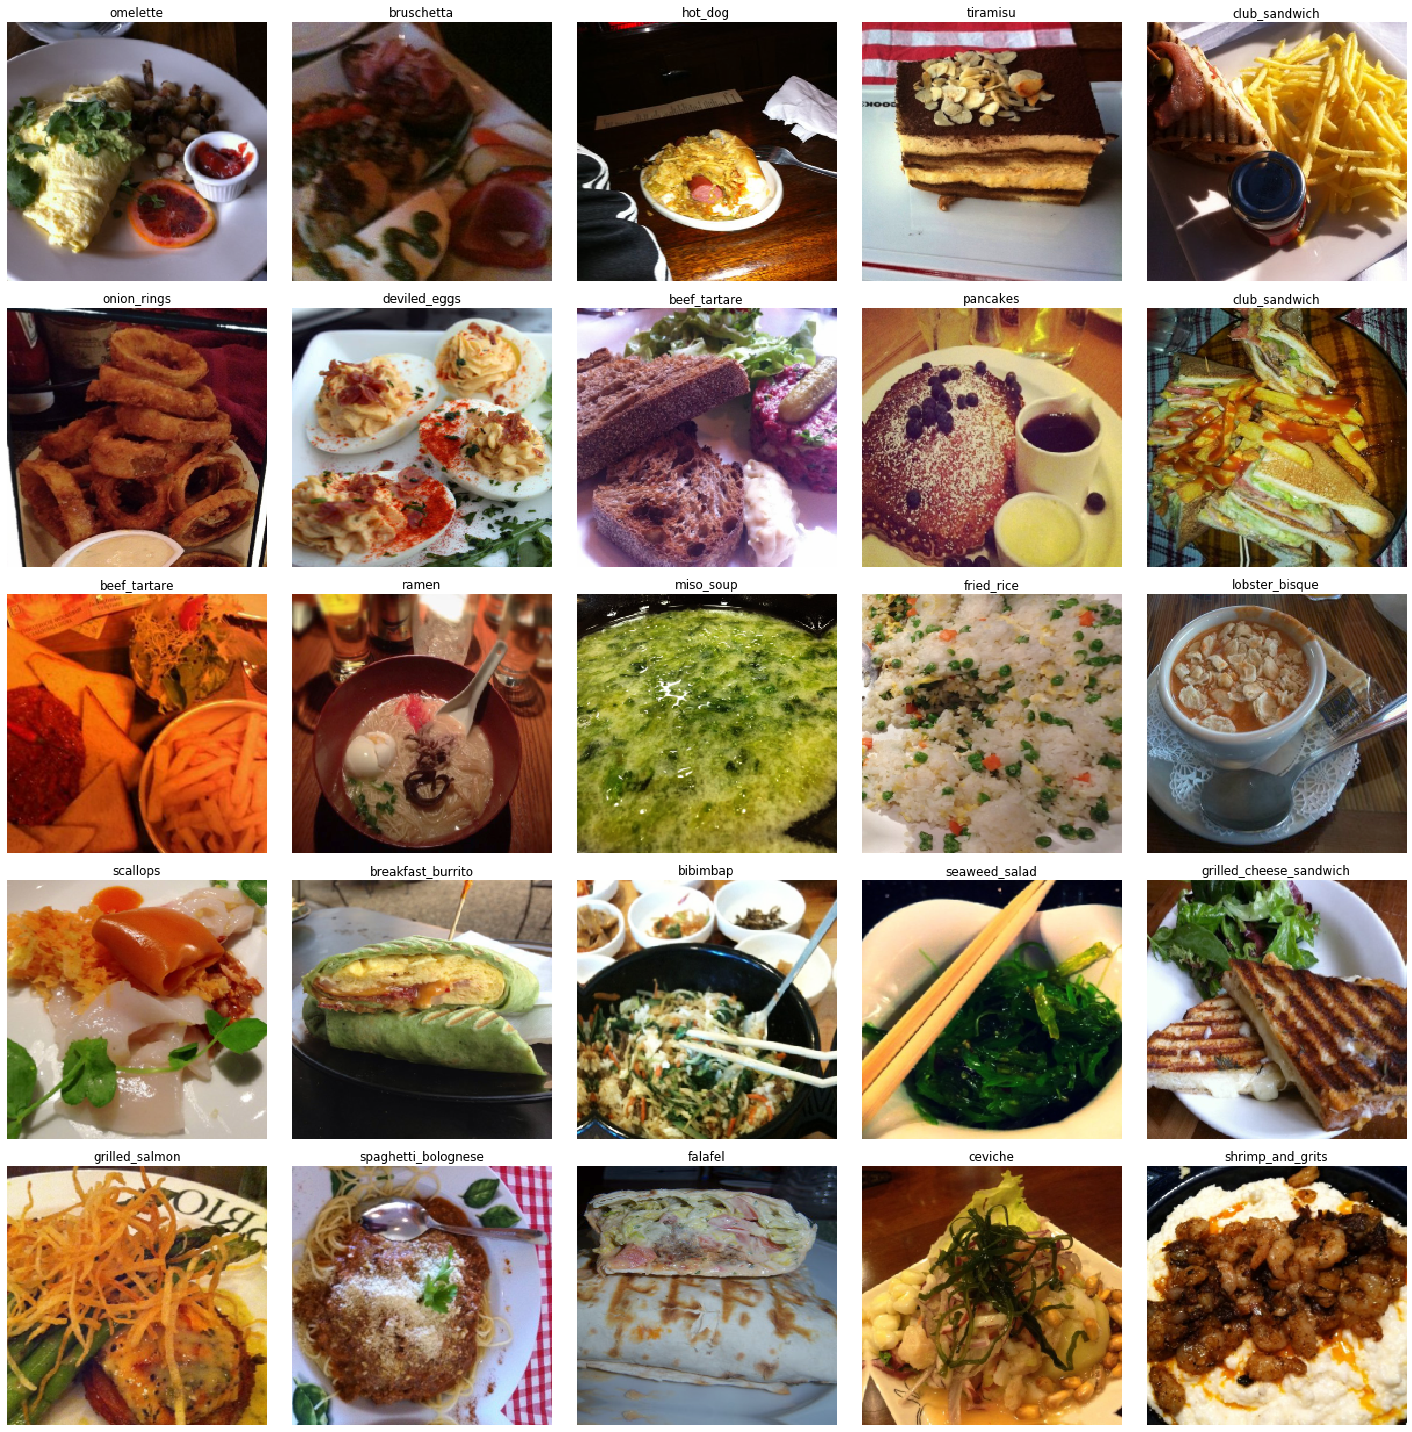

In [167]:
data.show_batch()

In [168]:
data.c

101

## Learner creation

Using the resnet 50 as recommended

In [196]:
learner = cnn_learner(data, models.resnet50, metrics = [error_rate, accuracy]).mixup()

First running a learning rate finder on the frozen model to train final layer exclusively. I choose 5e-3

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


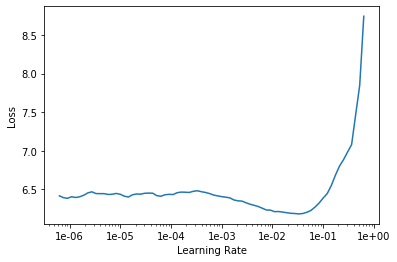

In [197]:
learner.lr_find()

learner.recorder.plot()

In [13]:
learner.fit_one_cycle(4, max_lr=5e-3, pct_start=0.3)

In [14]:
#saving model
learner.save('model50_2pt1')

Now I am unfreezing the model and doing an learning rate search again

In [15]:
learner.unfreeze()
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


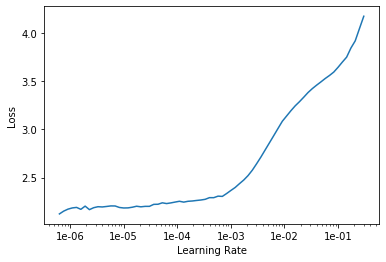

In [16]:
learner.recorder.plot()

Reloaded from savepoint because lr_find() takes a model's parameters to a point beyond recovery. 
For the first lr test, I usually just recreate the model.

In [18]:
learner.load('model50_2pt1');
learner.unfreeze()

In [19]:
#checking if callbacks are still attached to model after reload.
learner.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False),
 functools.partial(<class 'fastai.callbacks.mixup.MixUpCallback'>, alpha=0.4, stack_x=False, stack_y=True)]

In [20]:
learner.fit_one_cycle(10, max_lr = slice(2e-5, 2e-4), pct_start = 0.6)

In [21]:
learner.save('model50_2pt2')

The training is complete with a **total accuracy of 85.28%**

## Inference with FastAI

In [170]:
learner.load('model50_2pt2')

Learner(data=ImageDataBunch;

Train: LabelList (75750 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: /media/data/data archive/food/food-101/images;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: /media/data/data archive/food/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1,

In [22]:
interp = ClassificationInterpretation.from_learner(learner) 
# learner.top_losses()

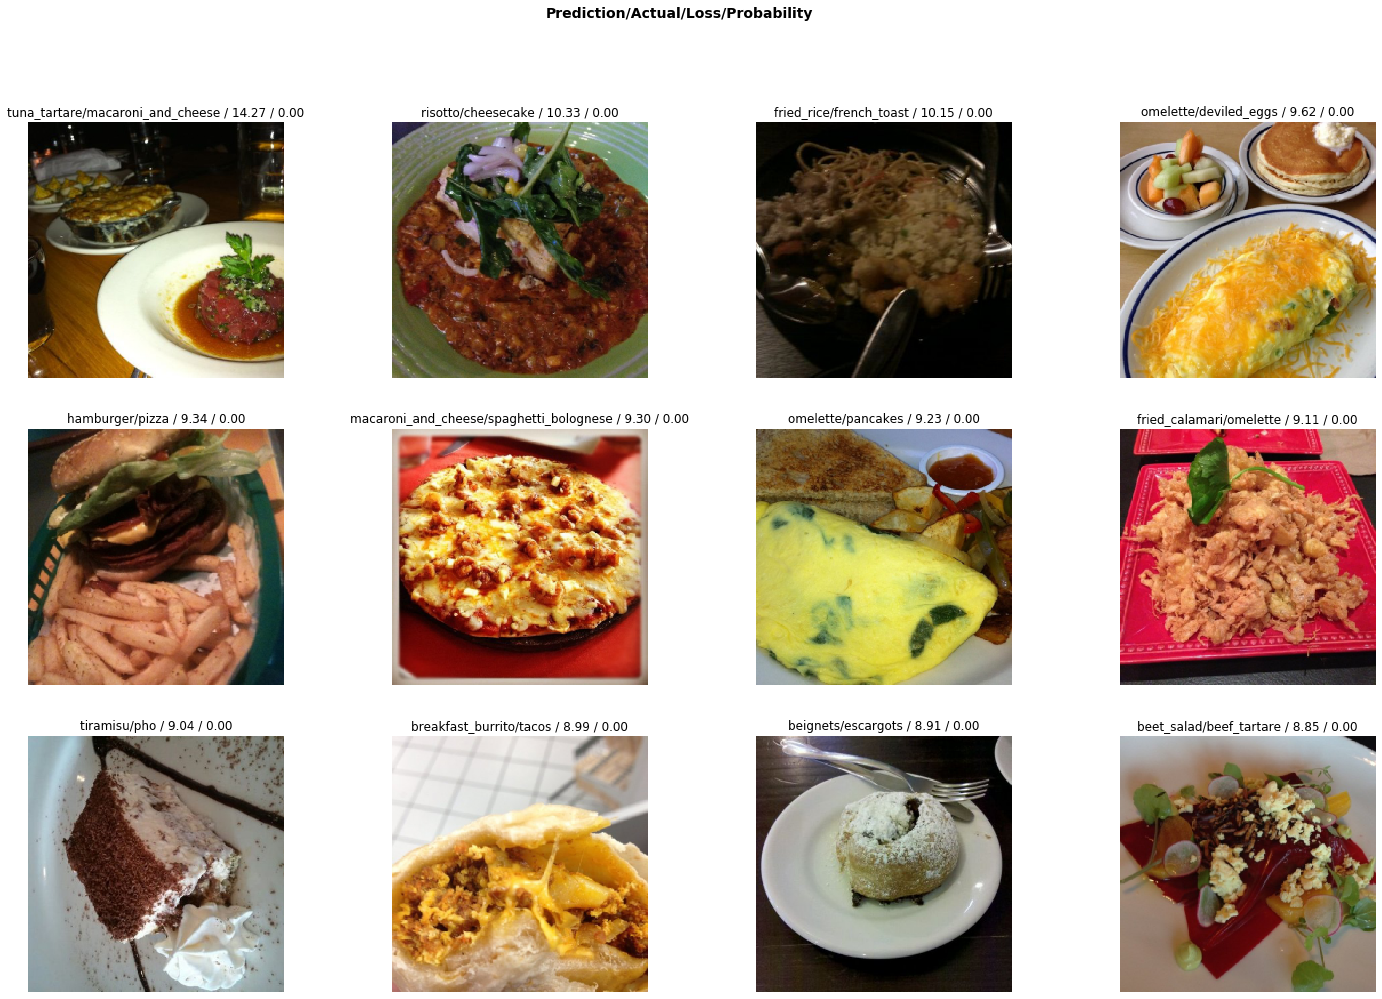

In [26]:
interp.plot_top_losses(12, figsize = (25,16))

A quick look at the images shows us that these are all images with noisy labels. While some may be attributed to label decision ambiguity, it is clear that tiramisu (row 3, col 1) can never be pho!

In [182]:
learner.export()